# Analysing missing persons data from the NamUs website
### 1. Acquire the data from the website
### 2. Save the data to a local file
### 3. Remove null values from the data
### 4. Describe the data
### 5. Visualize the data

In [1]:
import pandas as pd
import requests
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import json
import time


### Acquiring the data from the website and saving it to a local file on the machine

In [2]:
DEST_FILE = "missing_persons.json"
missing_persons_url = "https://www.namus.gov/api/CaseSets/NamUs/MissingPersons/Search"

# number of records to query
# max take is 1000 i think
COUNT = 150


filtering_parameters = {
    "predicates":[],
    "take":COUNT,
    "skip":0,
    "projections":[
        "idFormatted",
        "dateOfLastContact",
        "lastName",
        "firstName",
        "computedMissingMinAge",
        "computedMissingMaxAge",
        "cityOfLastContact",
        "countyDisplayNameOfLastContact",
        "stateDisplayNameOfLastContact",
        "gender",
        "raceEthnicity",
        "modifiedDateTime",
        "namus2Number"
    ],
    "orderSpecifications":[
        {
            "field":"dateOfLastContact",
            "direction":"Descending"
        }
    ]
}

### Cleaning the data
   #### Dropping null values
   #### Converting date formats

In [3]:
# make a request to the url and filter the data and retrieve the data in json format
missing_persons_data = requests.post(missing_persons_url, json=filtering_parameters).json()

# get the data in the 'results' key
with open(DEST_FILE, "w") as dest_:
    json.dump(missing_persons_data['results'], dest_)
        
# convert json data to pd dataframe
missing_persons_df = pd.read_json(DEST_FILE)
missing_persons_df.index = range(len(missing_persons_df))

# Drop the columns we don't need
missing_persons_df.drop(columns=['idFormatted', 'modifiedDateTime', 'namus2Number', 'currentAgeFrom', 'currentAgeTo'], inplace=True)

# change the date to readable format
missing_persons_df['dateOfLastContact'] = missing_persons_df['dateOfLastContact'].apply(lambda x: time.ctime(datetime.fromisoformat(x).timestamp()))


# drop rows with missing values in place
missing_persons_df.dropna(axis=0, inplace=True)

# check for missing values
missing_persons_df.isna().sum()

# describe the dataset
missing_persons_df.describe()

,computedMissingMinAge,computedMissingMaxAge
count,149.000000,149.000000
mean,25.973154,25.973154
std,16.085475,16.085475
min,7.000000,7.000000
25%,16.000000,16.000000
50%,17.000000,17.000000
75%,33.000000,33.000000
max,75.000000,75.000000


### Extracting some information concerning the missing people from the data
   #### Minimum & Maximum ages of the people missing

In [4]:
# find the youngest person to go missing
missing_persons_df['computedMissingMaxAge'].min()

# find the youngest person to go missing
missing_persons_df['computedMissingMinAge'].max()

# find the number of missing females vs males in the data
missing_persons_df['gender'].value_counts()


Female    81
Male      67
Other      1
Name: gender, dtype: int64

In [5]:
# group the genders by city of last contact and number
missing_persons_df.groupby('cityOfLastContact').gender.value_counts()

cityOfLastContact  gender
Alva               Female    1
Anchorage          Male      2
                   Female    1
Ardmore            Female    2
Asheville          Male      5
                            ..
Wethersfield       Male      1
Williams           Female    1
Yardley            Male      1
Yuma               Female    1
mattapan           Female    1
Name: gender, Length: 112, dtype: int64

In [6]:
#resetting the index of the dataset
missing_persons_df.index = range(len(missing_persons_df))
missing_persons_df.head()

,dateOfLastContact,lastName,firstName,computedMissingMinAge,computedMissingMaxAge,cityOfLastContact,countyDisplayNameOfLastContact,stateDisplayNameOfLastContact,gender,raceEthnicity,link,image,missingAgeRangeValue
0,Tue Oct 31 00:00:00 2023,Hernandez,Anahi,16.0,16.0,Goodyear,Maricopa,AZ,Female,White / Caucasian,/MissingPersons/Case#/110874,/api/CaseSets/NamUs/MissingPersons/Cases/11087...,16 Years
1,Sat Oct 28 00:00:00 2023,Adams,Dezerae,16.0,16.0,Ardmore,Oklahoma,OK,Female,American Indian / Alaska Native,/MissingPersons/Case#/110761,/api/CaseSets/NamUs/MissingPersons/Cases/11076...,16 Years
2,Sat Oct 28 00:00:00 2023,Skye,Cummings,16.0,16.0,Pryor,Mayes,OK,Female,White / Caucasian,/MissingPersons/Case#/110820,/api/CaseSets/NamUs/MissingPersons/Cases/11082...,16 Years
3,Fri Oct 27 00:00:00 2023,Purser-Fabrizio,Amy,50.0,50.0,Springdale,Washington,AR,Female,White / Caucasian,/MissingPersons/Case#/110753,/api/CaseSets/NamUs/MissingPersons/Cases/11075...,50 Years
4,Fri Oct 27 00:00:00 2023,Kelsey,Kassidy,17.0,17.0,Mead,Bryan,OK,Female,American Indian / Alaska Native,/MissingPersons/Case#/110772,/api/CaseSets/NamUs/MissingPersons/Cases/11077...,17 Years


<Figure size 432x288 with 0 Axes>

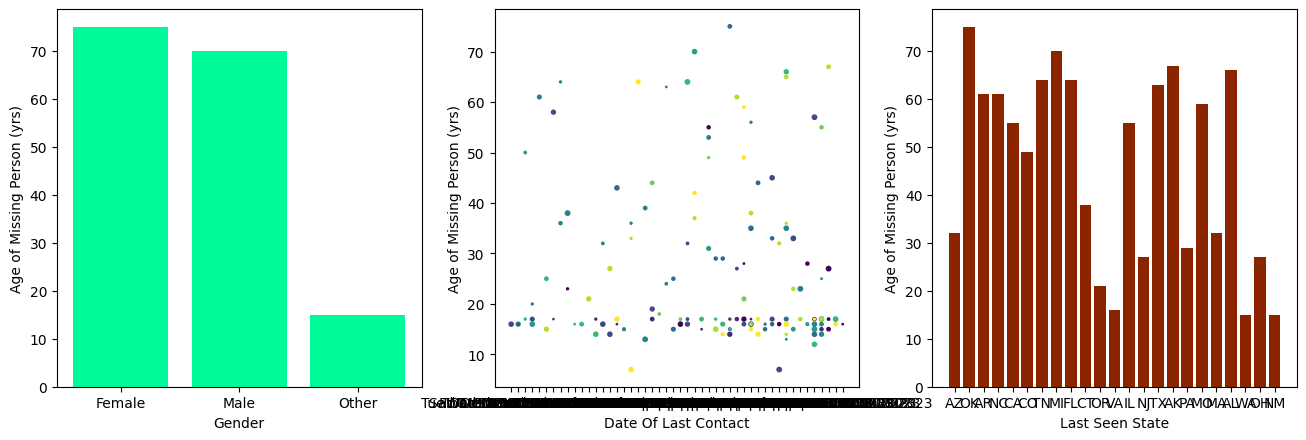

In [7]:
plt.suptitle('Missing Persons Data')
figure(num=None, figsize=(16, 5), dpi=100, facecolor='#fff', edgecolor='g', frameon=True)

# colors for the bar plot
colors = ['#00fa9a']

# bar plot of age of missing persons against gender
# we can see that the oldest female to go missing was around 75 yrs from the current dataset
plt.subplot(131)
plt.xlabel('Gender')
plt.ylabel('Age of Missing Person (yrs)')
plt.bar(
    missing_persons_df['gender'],
    missing_persons_df['computedMissingMinAge'],
    color=colors
)

# scatter plot of age of missing persons against date of last contact
plt.subplot(132)
plt.xlabel('Date Of Last Contact')
plt.ylabel('Age of Missing Person (yrs)')
plt.scatter(
    'dateOfLastContact',
    'computedMissingMaxAge',
    c=np.random.randint(0, 10, missing_persons_df.shape[0]),
    s=np.random.randint(1, 11, missing_persons_df.shape[0]),
    data=missing_persons_df
)

# bar plot of age of missing persons against their last seen state
plt.subplot(133)
plt.xlabel('Last Seen State')
plt.ylabel('Age of Missing Person (yrs)')
plt.bar(
    missing_persons_df['stateDisplayNameOfLastContact'],
    missing_persons_df['computedMissingMaxAge'],
    color='#8b2500'
)

# display the plots
plt.show()

## Bar chart & Scatter plot on polar axis

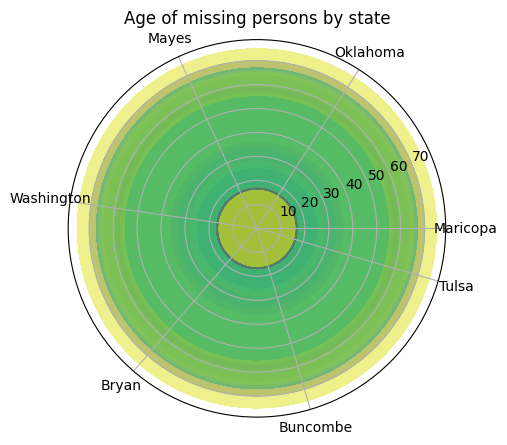

In [8]:
figure(num=None, figsize=(5, 5), dpi=100, facecolor='#fff', edgecolor='g', frameon=True)

np.random.seed(19680801)

plt.subplot(131)
# Compute pie slices for the data
N = np.int64(missing_persons_df['computedMissingMinAge'].max())
radii = 10 * np.random.rand(N)

# width = np.pi / 4 * np.random.rand(N)
width = np.pi /3.2 *  missing_persons_df['computedMissingMinAge']
colors = plt.cm.viridis(radii / 10.)

ax = plt.subplot(projection='polar')
ax.bar(
    'countyDisplayNameOfLastContact',
    'computedMissingMinAge',
    data=missing_persons_df,
    width=missing_persons_df['computedMissingMinAge'],
    bottom=0.0,
    color=colors,
    alpha=0.5
)

ax.set_title('Age of missing persons by state')
plt.show()

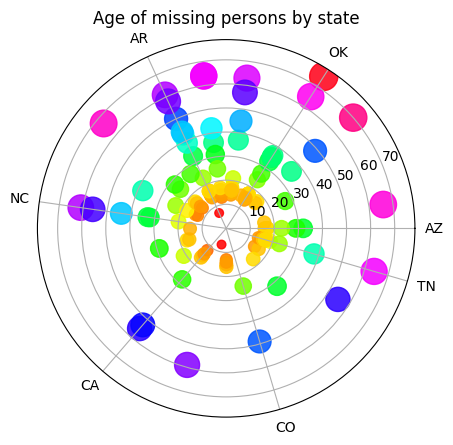

In [9]:
# specify the size of the plot and the projection type of the subplot
figure(num=None, figsize=(5, 5), dpi=100, facecolor='#fff', edgecolor='g', frameon=True)
ax = plt.subplot(projection='polar')

# Compute areas and colors
r = missing_persons_df['computedMissingMinAge']
theta = missing_persons_df['stateDisplayNameOfLastContact']
area = missing_persons_df['computedMissingMinAge']
colors = missing_persons_df['computedMissingMinAge']

c = ax.scatter(
    theta,
    r, #value of ages on the inner circles
    c=colors, #color of the ages
    s=missing_persons_df['computedMissingMinAge'] * 5.5, #take the value of missing age * 7.5 to make cicrcles larger
    cmap='hsv',
    alpha=0.86 #transparency of the circles
)

ax.set_title('Age of missing persons by state')

# show the polar plot
plt.show()

## Group the data into states and plot the missing ages for each state
   ### Add some text for the labels, title and custom x-axis tick labels

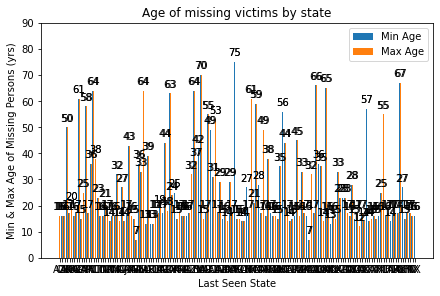

In [10]:
missing_person_state = missing_persons_df['stateDisplayNameOfLastContact']

missing_persons_details = {
    "Min Age": tuple(missing_persons_df['computedMissingMinAge'].values), 
    "Max Age": tuple(missing_persons_df['computedMissingMaxAge'].values)
}

x = np.arange(len(missing_person_state.values))

width = 0.35 # the width of the bars 
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in missing_persons_details.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=4) 
    multiplier += 1
    
# add text for the labels
ax.set_ylabel('Min & Max Age of Missing Persons (yrs)')
ax.set_xlabel('Last Seen State')
ax.set_title('Age of missing victims by state')
ax.set_xticks(x + width, missing_person_state)
ax.legend(loc='upper right')
ax.set_ylim(0, 90)

plt.show()